In [1]:
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
import corner
from CCE import * 
from scipy.optimize import differential_evolution
from pathlib import Path
from bgp_qnm_fits import *

In [2]:
id = "0001"

In [3]:
with open("param_dict.pkl", "rb") as f:
    param_dict = pickle.load(f)
    
with open("R_dict.pkl", "rb") as f:
    R_dict = pickle.load(f)

sim_main = SXS_CCE(id, lev="Lev5", radius="R2")

In [4]:
SIMNUMS = [
    "0001",
    "0002",
    "0003",
    "0004",
    "0005",
    "0006",
    "0007",
    "0008",
    "0009",
    "0010",
    "0011",
    "0012",
    "0013",
]
RINGDOWN_START_TIMES = [
    17.0,
    21.0,
    23.0,
    26.0,
    17.0,
    17.0,
    17.0,
    11.0,
    29.0,
    16.0,
    12.0,
    17.0,
    6.0,
]
TRAINING_SPH_MODES = [
    (2, 2),
    (2, 1),
    (3, 3),
    (3, 2),
    (4, 4),
    (2, -2),
    (2, -1),
    (3, -3),
    (3, -2),
    (4, -4),
]

SIM_TRAINING_MODE_RULES = {
    "0001": "PE",
    "0002": "PE",
    "0003": "PE",
    "0004": "PE",
    "0005": "P",
    "0006": "P",
    "0007": "P",
    "0008": "ALL",
    "0009": "E",
    "0010": "P",
    "0011": "P",
    "0012": "P",
    "0013": "ALL",
}

SMOOTHNESS = 16
EPSILON = 1 / 10

# These determine the parameter and training range but do not have to match `analysis times' used later.

TRAINING_START_TIME = -10
TRAINING_END_TIME = 100
TIME_STEP = 0.1

analysis_times = np.arange(
    TRAINING_START_TIME,
    TRAINING_START_TIME + TRAINING_END_TIME,
    TIME_STEP,
)  

# Define training bounds

SIGMA_MAX_LOWER, SIGMA_MAX_UPPER = 0.05, 5
T_S_LOWER, T_S_UPPER = -20, 30
LENGTH_SCALE_LOWER, LENGTH_SCALE_UPPER = 0.1, 5
PERIOD_LOWER, PERIOD_UPPER = 0.1, 5

SMOOTHNESS_LOWER, SMOOTHNESS_UPPER = 0, 30
LENGTH_SCALE_2_LOWER, LENGTH_SCALE_2_UPPER = 0.1, 5
PERIOD_2_LOWER, PERIOD_2_UPPER = 0.1, 5
A_LOWER, A_UPPER = 0, 0.9

BOUNDS_WN = [
    (SIGMA_MAX_LOWER, SIGMA_MAX_UPPER),
]

BOUNDS_GP = [
    (SIGMA_MAX_LOWER, SIGMA_MAX_UPPER),
    (T_S_LOWER, T_S_UPPER),
    (LENGTH_SCALE_LOWER, LENGTH_SCALE_UPPER),
    (PERIOD_LOWER, PERIOD_UPPER),
]

BOUNDS_GPC = [
    (SIGMA_MAX_LOWER, SIGMA_MAX_UPPER),
    (T_S_LOWER, T_S_UPPER),
    (SMOOTHNESS_LOWER, SMOOTHNESS_UPPER),
    (LENGTH_SCALE_LOWER, LENGTH_SCALE_UPPER),
    (PERIOD_LOWER, PERIOD_UPPER),
    (LENGTH_SCALE_2_LOWER, LENGTH_SCALE_2_UPPER),
    (PERIOD_2_LOWER, PERIOD_2_UPPER),
    (A_LOWER, A_UPPER),
]

# Set initial params

# INITIAL_PARAMS_WN = [1.]
# INITIAL_PARAMS_GP = [1.0, 0.0, 1.0, 1.0]
# INITIAL_PARAMS_GPC = [0.5715534011443748, 0.0032311845355438894, SMOOTHNESS, 1.7176362780942858, 0.31558556618927797, 1.7176362780942858, 0.31558556618927797, 0.5]

INITIAL_PARAMS_WN = [0.29127733345656215]
INITIAL_PARAMS_GP = [
    0.2283378440307793,
    18.37394010821784,
    0.8610899535603144,
    0.2605530172829033,
]
# INITIAL_PARAMS_GPC = [0.5678699426741673, 3.3680141572797027, 7.841502124072786, 1.241209026430354, 0.9894982312667636, 0.1064862157208278, 0.139811581920352, 0.5917377132835934]
INITIAL_PARAMS_GPC = [
    0.29443340366568055,
    17.00880319694479,
    8.52342433839235,
    0.992215662729599,
    0.29792754163345136,
    1.4599452640915012,
    3.702622948813973,
    0.8844594560538273,
]

# Define rules for updating params

HYPERPARAM_RULE_DICT_WN = {
    "sigma_max": "multiply",
}

HYPERPARAM_RULE_DICT_GP = {
    "sigma_max": "multiply",
    "t_s": "sum",
    "length_scale": "multiply",
    "period": "multiply",
}

HYPERPARAM_RULE_DICT_GPC = {
    "sigma_max": "multiply",
    "t_s": "sum",
    "sharpness": "replace",
    "length_scale": "multiply",
    "period": "multiply",
    "length_scale_2": "multiply",
    "period_2": "multiply",
    "a": "replace",
}

In [5]:
N_MAX = 2
qnm_list = [(2, 2, n, 1) for n in np.arange(0, N_MAX + 1)]
spherical_modes = [(2, 2)]
T0_REF = 17
T = 100 

In [ ]:
dts = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5] 
hyperparameters_array_test2 = np.zeros((len(dts), len(INITIAL_PARAMS_GP)))
fits = [] 

for i, dt in enumerate(dts):

    new_times = np.arange(TRAINING_START_TIME, TRAINING_START_TIME+TRAINING_END_TIME, dt)
    R_dict_interp = {k:sim_interpolator_data(v, analysis_times, new_times) for k, v in R_dict.items()}

    hyperparam_list, le, tuned_params = train_hyper_params(
        TRAINING_START_TIME,
        TRAINING_END_TIME,
        dt,
        INITIAL_PARAMS_GP,
        BOUNDS_GP,
        param_dict,
        R_dict_interp,
        HYPERPARAM_RULE_DICT_GP,
        kernel_main,
        TRAINING_SPH_MODES,
        SIM_TRAINING_MODE_RULES,
    )

    hyperparameters_array_test2[i, :] = hyperparam_list


Optimal parameters: {'sigma_max': 0.7803019868194889, 't_s': 14.292701366504472, 'length_scale': 0.9200243082499862, 'period': 0.396597499624017} Log evidence: -1291091.9473958348
Tuning parameters...
Optimal parameters: {'sigma_max': 0.7752955093931837, 't_s': 14.165219277344093, 'length_scale': 0.9068438804554761, 'period': 0.3934950105182404} Log evidence: -852260.9270434795
Tuning parameters...
Optimal parameters: {'sigma_max': 0.7703479512558113, 't_s': 14.071278875935226, 'length_scale': 0.8987499670204384, 'period': 0.39112460406507565} Log evidence: -630588.4564854255
Tuning parameters...
Optimal parameters: {'sigma_max': 0.7654645243547917, 't_s': 14.03098803752129, 'length_scale': 0.8913558860058888, 'period': 0.38913770183123597} Log evidence: -498871.1614258106
Tuning parameters...
Optimal parameters: {'sigma_max': 0.76083367058779, 't_s': 14.024617809263997, 'length_scale': 0.8842440898959261, 'period': 0.3874140078499876} Log evidence: -412090.21774021303
Tuning parameter

In [ ]:
with open("hyperparameters_array_test.pkl", "wb") as f:
    pickle.dump(hyperparameters_array_test2, f)

In [ ]:
with open("hyperparameters_array_wn.pkl", "rb") as f:
    hyperparameters_array_wn = pickle.load(f)

with open("hyperparameters_array.pkl", "rb") as f:
    hyperparameters_array = pickle.load(f)

with open("hyperparameters_array_test.pkl", "rb") as f:
    hyperparameters_array_test = pickle.load(f)
    
dts = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5] 

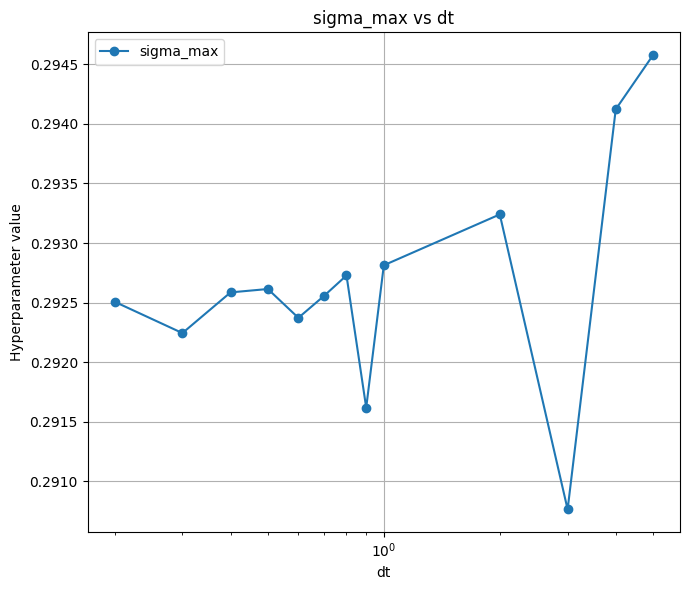

In [9]:
fig, ax = plt.subplots(figsize=(7, 6))
label = "sigma_max"

ax.plot(dts, hyperparameters_array_wn, marker='o', label=label)
ax.set_xlabel("dt")
ax.set_ylabel("Hyperparameter value")
ax.set_xscale("log")
ax.set_title("sigma_max vs dt")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


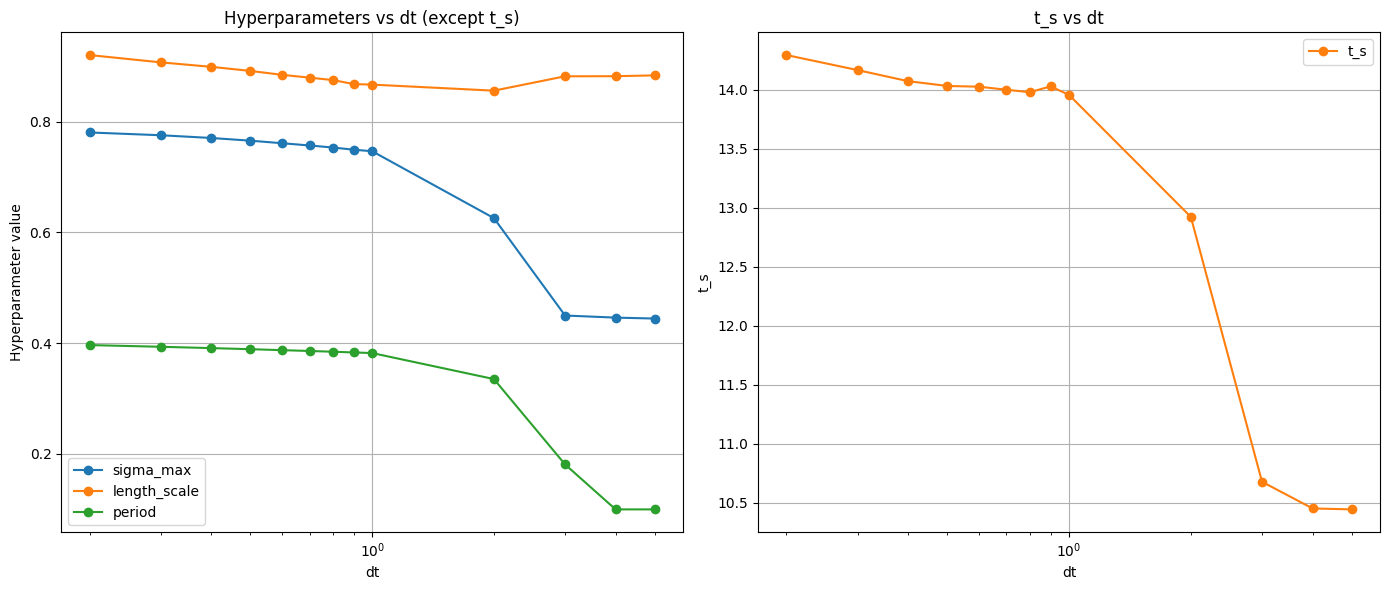

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharex=True)
labels = ["sigma_max", "t_s", "length_scale", "period"]

# Plot sigma_max, length_scale, period on the left
for i in [0, 2, 3]:
    ax1.plot(dts, hyperparameters_array_test[:, i], marker='o', label=labels[i])
ax1.set_xlabel("dt")
ax1.set_ylabel("Hyperparameter value")
ax1.set_xscale("log")
ax1.set_title("Hyperparameters vs dt (except t_s)")
ax1.legend()
ax1.grid(True)

# Plot t_s on the right
ax2.plot(dts, hyperparameters_array_test[:, 1], marker='o', color='tab:orange', label='t_s')
ax2.set_xlabel("dt")
ax2.set_ylabel("t_s")
ax2.set_xscale("log")
ax2.set_title("t_s vs dt")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


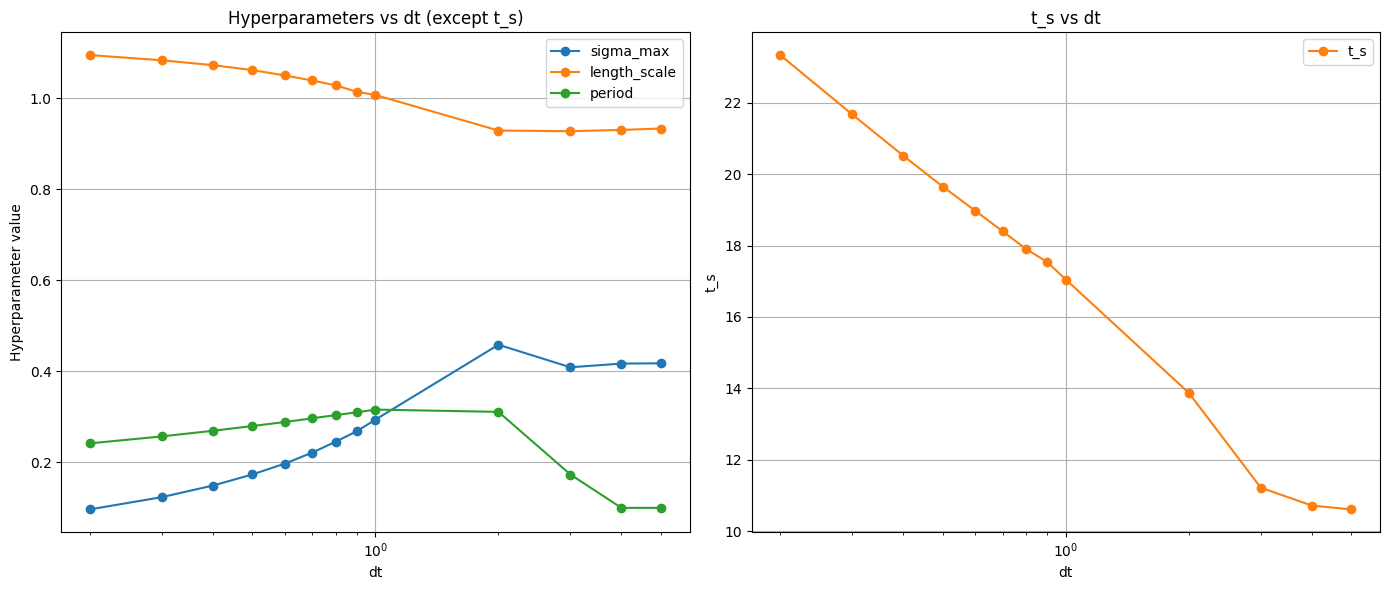

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharex=True)
labels = ["sigma_max", "t_s", "length_scale", "period"]

# Plot sigma_max, length_scale, period on the left
for i in [0, 2, 3]:
    ax1.plot(dts, hyperparameters_array[:, i], marker='o', label=labels[i])
ax1.set_xlabel("dt")
ax1.set_ylabel("Hyperparameter value")
ax1.set_xscale("log")
ax1.set_title("Hyperparameters vs dt (except t_s)")
ax1.legend()
ax1.grid(True)

# Plot t_s on the right
ax2.plot(dts, hyperparameters_array[:, 1], marker='o', color='tab:orange', label='t_s')
ax2.set_xlabel("dt")
ax2.set_ylabel("t_s")
ax2.set_xscale("log")
ax2.set_title("t_s vs dt")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [11]:
fits = []

for i, dt in enumerate(dts):

    sim_times_interp = np.arange(TRAINING_START_TIME, TRAINING_START_TIME+TRAINING_END_TIME, dt)
    sim_h_interp = sim_interpolator_data(sim_main.h, sim_main.times, sim_times_interp)
    
    tuned_param_GP = get_tuned_params(param_dict[id], hyperparameters_array[i], HYPERPARAM_RULE_DICT_GP)

    fit_GP = BGP_fit(
            sim_times_interp,
            sim_h_interp,
            qnm_list,
            sim_main.Mf,
            sim_main.chif_mag,
            tuned_param_GP,
            kernel_main,
            t0=T0_REF,
            num_samples=int(1e4),
            t0_method="geq",
            T=T,
            spherical_modes=spherical_modes,
            include_chif=True,
            include_Mf=True,
        )

    fits.append(fit_GP)

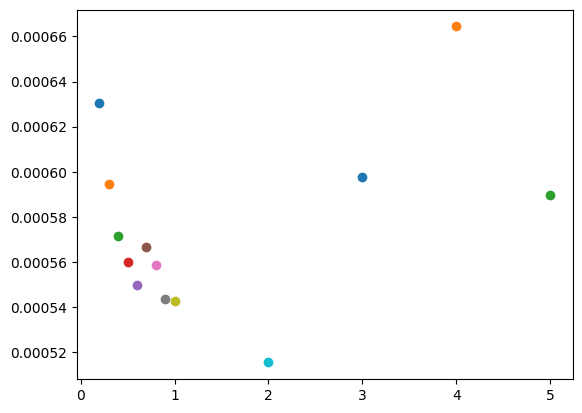

In [12]:
for i, fit in enumerate(fits):
    samples = fit.fit["samples"]
    std = np.std(samples, axis=0)
    plt.plot(dts[i], std[0], 'o')